# Portfolio Workflow

In [1]:
import logging
import logging.config

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('GenerateAIAlphaFactor')

import configparser
from platform import python_version
from pathlib import Path

# Project imports
import importlib
import tools.trading_factors_yahoo as alpha_factors
importlib.reload(alpha_factors)
import tools.utils as utils
importlib.reload(utils)
import tools.nonoverlapping_estimator as ai_estimator
importlib.reload(ai_estimator)

import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

Sci-Kit version: 1.1.3
Sci-Kit version: 1.1.3
2022-11-27 14:33:32,013|GenerateAIAlphaFactor|INFO|Python version: 3.8.15
2022-11-27 14:33:32,028|GenerateAIAlphaFactor|INFO|Pandas version: 1.5.2


In [2]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['AIAlpha']

# Price History data and Alphs Factors

In [3]:
price_histories_file_name = default_config['DataDirectory'] + '/' + default_config['PriceHistoriesFileName']
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
logger.info(f'Using {default_config["NumberOfYearsForAlpha"]} years of price history data to generate alpha factors.')
latest_date = price_histories.index.max() 
earliest_date = latest_date - pd.DateOffset(years=int(default_config["NumberOfYearsForAlpha"]))
price_histories = price_histories[(price_histories.index >= earliest_date) & (price_histories.index <= latest_date)]
logger.info(f'PRICE_HISTORIES_ALPHA|{price_histories.index.min()}|{price_histories.index.max()}')
close = price_histories.Close
logger.info(f'STOCK_TICKERS|{len(close.columns)}')
alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AlphaFactorsFileName']

logger.info(f'ALPHA_FACTORS_FILE|{alpha_factors_file_name}')
all_factors = pd.read_csv(alpha_factors_file_name, parse_dates=['Date']).set_index(['Date', 'Symbols']).sort_index()
logger.info('Alpha factors read.')

for alpha_factor in all_factors.columns:
    logger.info(f'ALPHA_FACTOR|{alpha_factor}')

2022-11-27 14:33:50,647|GenerateAIAlphaFactor|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-27 14:33:51,788|GenerateAIAlphaFactor|INFO|PRICE_HISTORIES|2017-11-27 00:00:00|2022-11-25 00:00:00
2022-11-27 14:33:51,789|GenerateAIAlphaFactor|INFO|Using 5 years of price history data to generate alpha factors.
2022-11-27 14:33:51,805|GenerateAIAlphaFactor|INFO|PRICE_HISTORIES_ALPHA|2017-11-27 00:00:00|2022-11-25 00:00:00
2022-11-27 14:33:51,808|GenerateAIAlphaFactor|INFO|STOCK_TICKERS|501
2022-11-27 14:33:51,809|GenerateAIAlphaFactor|INFO|ALPHA_FACTORS_FILE|./data/all_factors.csv
2022-11-27 14:33:52,646|GenerateAIAlphaFactor|INFO|Alpha factors read.
2022-11-27 14:33:52,647|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|trailing_overnight_returns_10_day_smoothed
2022-11-27 14:33:52,647|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|market_dispersion_120_day
2022-11-27 14:33:52,648|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|market_volatility_120_day


# Stage 3: Generate AI Alpha Factor

- Compute target values (y)
    - Quantize with 2 bins
- Train model for Feature importance
- Feature reduction
- Train model for AI Alpha Vector
- Compute AI Alpha Vectors for 1 year
- Save AI Alpha Vectors

## Compute the target values (y) and Shift back to create a 5 day forward prediciton

This is something you want to experiment with. If you are planning on holding on to assets for long periods of time, perhaps a 20, 40 or 60 forward prediciton will work better.

In [4]:
forward_prediciton_days = int(default_config['ForwardPredictionDays'])
prod_target_quantiles = int(default_config['PredictionQuantiles'])
prod_target_source = f'{forward_prediciton_days}Day{prod_target_quantiles}Quant'

logger.info(f'Setting {forward_prediciton_days} days-{prod_target_quantiles} quantiles to target {prod_target_source}')
all_assets = all_factors.index.levels[1].values.tolist()
logger.info(f'Factors from date: {all_factors.index.levels[0].min()} to date: {all_factors.index.levels[0].max()}')
features = all_factors.columns.tolist()

training_factors = pd.concat(
[
    all_factors,
    alpha_factors.FactorReturnQuantiles(price_histories, prod_target_quantiles, forward_prediciton_days).for_al(prod_target_source),
], axis=1).dropna()
training_factors.sort_index(inplace=True)

training_factors['target'] = training_factors.groupby(level=1)[prod_target_source].shift(-forward_prediciton_days)

logger.info(f'Creating training and label data...')
temp = training_factors.dropna().copy()
X = temp[features]
y = temp['target']
for feature in features:
    logger.info(f'TRAINING_FEATURE|{feature}')
logger.info(f'TRAINING_DATASET|{len(X)}|LABEL_DATASET|{len(y)}')

2022-11-27 14:34:03,652|GenerateAIAlphaFactor|INFO|Setting 5 days-2 quantiles to target 5Day2Quant
2022-11-27 14:34:03,653|GenerateAIAlphaFactor|INFO|Factors from date: 2018-05-21 00:00:00 to date: 2022-11-25 00:00:00
2022-11-27 14:34:10,583|GenerateAIAlphaFactor|INFO|Creating training and label data...
2022-11-27 14:34:10,637|GenerateAIAlphaFactor|INFO|TRAINING_FEATURE|trailing_overnight_returns_10_day_smoothed
2022-11-27 14:34:10,638|GenerateAIAlphaFactor|INFO|TRAINING_FEATURE|market_dispersion_120_day
2022-11-27 14:34:10,638|GenerateAIAlphaFactor|INFO|TRAINING_FEATURE|market_volatility_120_day
2022-11-27 14:34:10,639|GenerateAIAlphaFactor|INFO|TRAINING_DATASET|568134|LABEL_DATASET|568134


In [5]:
from sklearn.ensemble import RandomForestClassifier

n_days = 10
n_stocks = len(set(all_factors.index.get_level_values(level=1).values))
clf_random_state = 42

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_days * n_stocks,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': clf_random_state}

n_trees = int(default_config['RandomForestNTrees'])

logger.info(f'Creating RandomForestClassifier with {n_trees} trees...')
for key, value in clf_parameters.items():
    logger.info(f'Parameter: {key} set to {value}')
clf = RandomForestClassifier(n_trees, **clf_parameters)

logger.info(f'Creating Non-Overalpping Voter with {forward_prediciton_days-1} non-overlapping windows...')
clf_nov = ai_estimator.NoOverlapVoter(clf, n_skip_samples=forward_prediciton_days-1)

logger.info(f'Training classifier...')
clf_nov.fit(X, y)

logger.info(f'CLASSIFIER|TRAIN|{clf_nov.score(X, y.values)}|OOB|{clf_nov.oob_score_}')

2022-11-27 14:34:19,790|GenerateAIAlphaFactor|INFO|Creating RandomForestClassifier with 5000 trees...
2022-11-27 14:34:19,792|GenerateAIAlphaFactor|INFO|Parameter: criterion set to entropy
2022-11-27 14:34:19,793|GenerateAIAlphaFactor|INFO|Parameter: min_samples_leaf set to 5010
2022-11-27 14:34:19,793|GenerateAIAlphaFactor|INFO|Parameter: oob_score set to True
2022-11-27 14:34:19,794|GenerateAIAlphaFactor|INFO|Parameter: n_jobs set to -1
2022-11-27 14:34:19,795|GenerateAIAlphaFactor|INFO|Parameter: random_state set to 42
2022-11-27 14:34:19,796|GenerateAIAlphaFactor|INFO|Creating Non-Overalpping Voter with 4 non-overlapping windows...
2022-11-27 14:34:19,797|GenerateAIAlphaFactor|INFO|Training classifier...
2022-11-27 14:47:04,625|GenerateAIAlphaFactor|INFO|CLASSIFIER|TRAIN|0.5098409882175684|OOB|0.5028078574440531


In [6]:
ai_alpha_name = default_config['AIAlphaName']
logger.info(f'AIAlpha|GETSCORE|{ai_alpha_name}')
factors_with_alpha = alpha_factors.add_alpha_score(training_factors[features].copy(), clf_nov, ai_alpha_name)
logger.info(f'Factors with AIAlpha from date: {factors_with_alpha.index.levels[0].min()} to date: {factors_with_alpha.index.levels[0].max()}')
for alpha_factor in factors_with_alpha.columns:
    logger.info(f'ALPHA_FACTOR|{alpha_factor}')

2022-11-27 14:49:32,774|GenerateAIAlphaFactor|INFO|AIAlpha|GETSCORE|AI_ALPHA
2022-11-27 14:54:19,248|GenerateAIAlphaFactor|INFO|Factors with AIAlpha from date: 2017-12-04 00:00:00 to date: 2022-11-25 00:00:00
2022-11-27 14:54:19,249|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|trailing_overnight_returns_10_day_smoothed
2022-11-27 14:54:19,250|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|market_dispersion_120_day
2022-11-27 14:54:19,251|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|market_volatility_120_day
2022-11-27 14:54:19,251|GenerateAIAlphaFactor|INFO|ALPHA_FACTOR|AI_ALPHA


C:\Users\HP-Z440\Anaconda Projects\svi-trading-tools\tools\trading_factors_yahoo.py:298: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  clean_factor_data = {
C:\Users\HP-Z440\anaconda3\envs\svi_tt_p308\lib\site-packages\alphalens\utils.py:352: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  delta_days = period_len.components.days - mode(days_diffs).mode[0]
C:\Users\HP-Z440\anaconda3\envs\svi_tt_p308\lib\site-packages\alphalens\utils.py:185: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included i

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!

-----------------------



C:\Users\HP-Z440\anaconda3\envs\svi_tt_p308\lib\site-packages\alphalens\performance.py:204: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  weights = factor_data.groupby(grouper)["factor"].apply(


             Sharpe Ratios
          Sharpe Ratio
AI_ALPHA          1.62


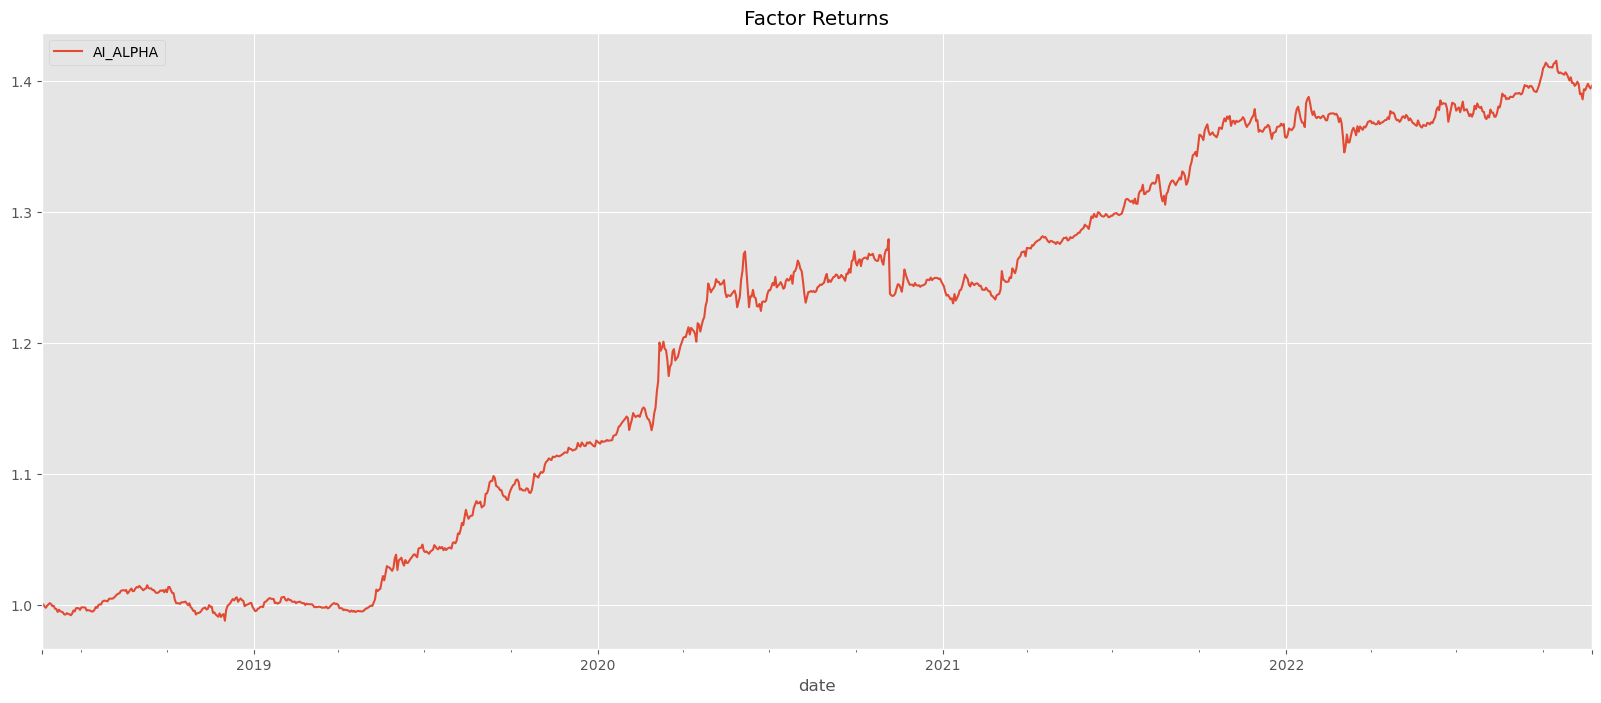

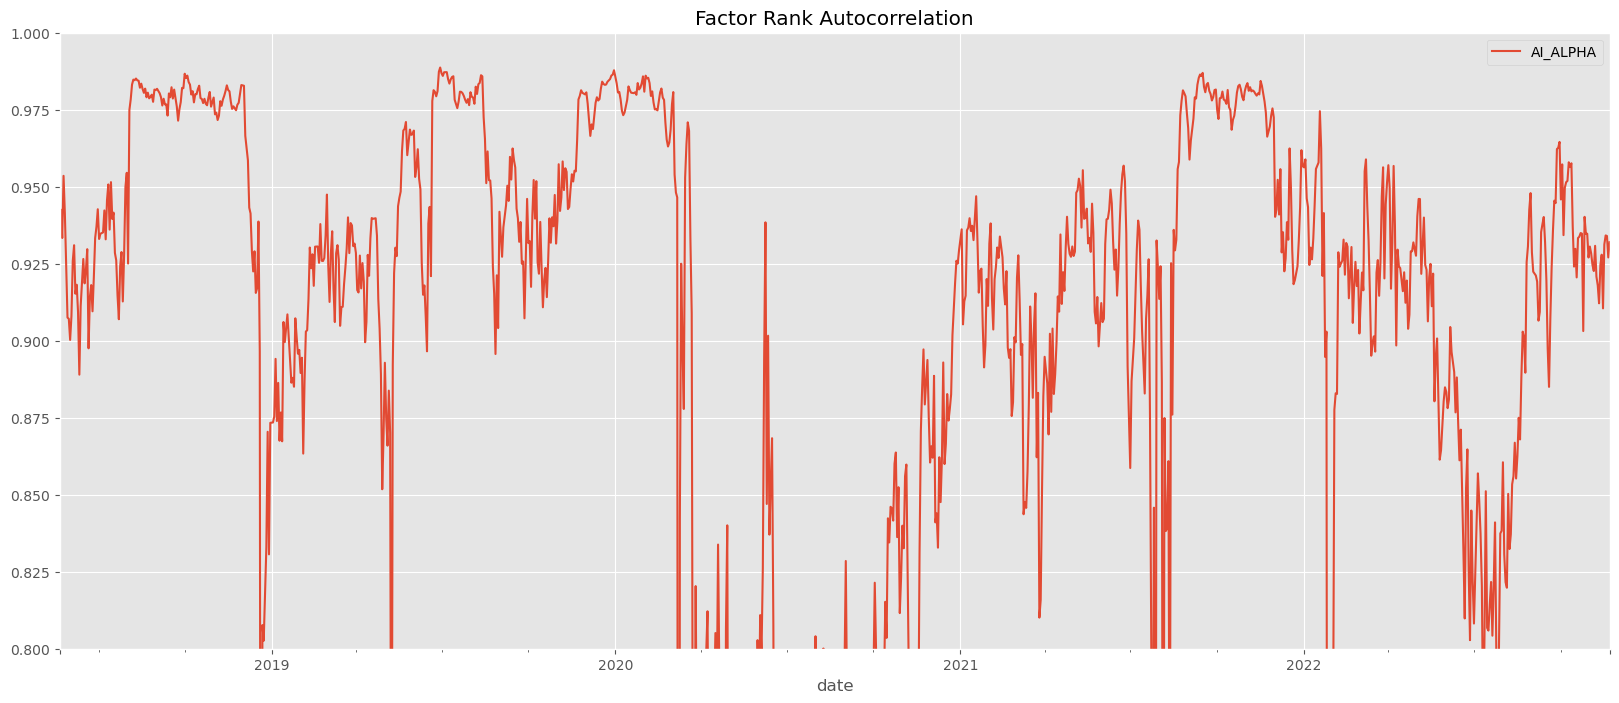

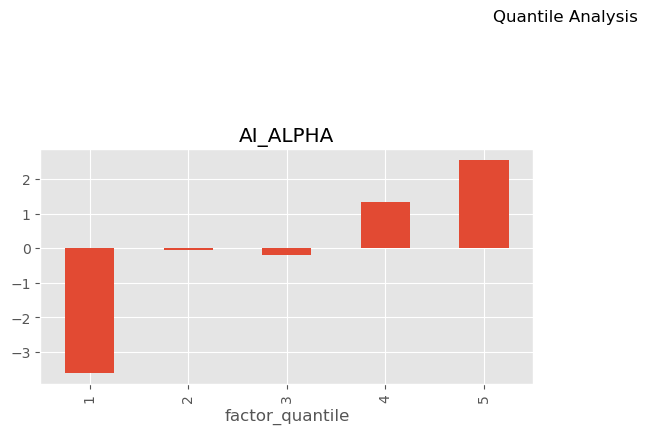

In [7]:
factors_to_compare = features
_ = alpha_factors.evaluate_alpha(factors_with_alpha[[ai_alpha_name]], close)

In [8]:
ai_alpha = factors_with_alpha[ai_alpha_name].copy()
alpha_vectors = ai_alpha.reset_index().pivot(index='Date', columns='Symbols', values=ai_alpha_name)
ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')
alpha_vectors.reset_index().to_csv(ai_alpha_factors_file_name, index=False)

2022-11-27 14:58:00,110|GenerateAIAlphaFactor|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv


## TODO:

- Evaluate model
- Save model

In [10]:
pre_backtest_model_file_name = default_config['DataDirectory'] + '/' + default_config['model_file_name']

with open(pre_backtest_model_file_name, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(clf_nov, f, pickle.HIGHEST_PROTOCOL)